# Split into Dist

Root client data saved in 'dataset/root_client'.
Data for each client saved in 'dataset/clients' using IID distribution.


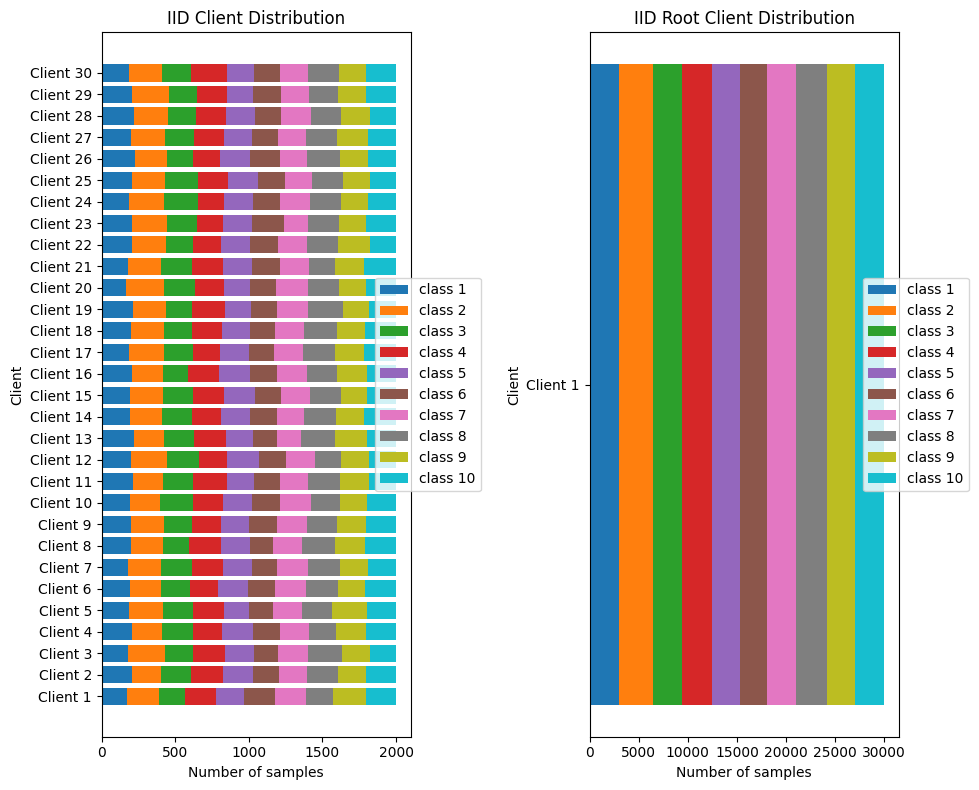

In [7]:
import os
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

# Function to compute class distributions for a set of client data
def compute_class_distributions(client_data, num_classes=10):
    distributions = []
    for x_client, y_client in client_data:
        class_counts = np.bincount(y_client, minlength=num_classes)
        distributions.append(class_counts)
    return np.array(distributions).T  # Transpose to get a list of class-wise distributions

# Function to create and save data splits (IID or random)
def create_client_splits(x_data, y_data, num_clients, distribution='iid'):
    client_data = []
    num_samples = len(x_data)
    indices = list(range(num_samples))

    if distribution == 'iid':
        # IID split: Each client gets an equal share of the data
        random.shuffle(indices)
        split_size = num_samples // num_clients
        for i in range(num_clients):
            start_idx = i * split_size
            end_idx = (i + 1) * split_size
            client_indices = indices[start_idx:end_idx]
            client_data.append((x_data[client_indices], y_data[client_indices]))
    else:
        # Non-IID split: Random class assignment per client
        unique_classes = np.unique(y_data)
        class_indices = {cls: np.where(y_data == cls)[0].tolist() for cls in unique_classes}

        for i in range(num_clients):
            client_indices = []
            for cls in unique_classes:
                num_class_samples = random.randint(0, len(class_indices[cls]) // num_clients)
                selected_indices = random.sample(class_indices[cls], num_class_samples)
                client_indices.extend(selected_indices)

                # Remove the selected indices to avoid repeating
                class_indices[cls] = list(set(class_indices[cls]) - set(selected_indices))

            client_data.append((x_data[client_indices], y_data[client_indices]))

    return client_data

# Save the split data for each client as .npy files
def save_client_data(client_data, save_dir, distribution):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i, (x_client, y_client) in enumerate(client_data):
        client_dir = os.path.join(save_dir, f'client_{i+1}')
        if not os.path.exists(client_dir):
            os.makedirs(client_dir)

        np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
        np.save(os.path.join(client_dir, 'y_data.npy'), y_client)

    print(f"Data for each client saved in '{save_dir}' using {distribution.upper()} distribution.")

# Save root client data as .npy files
def save_root_client_data(x_root, y_root, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    np.save(os.path.join(save_dir, 'x_data.npy'), x_root)
    np.save(os.path.join(save_dir, 'y_data.npy'), y_root)

    print(f"Root client data saved in '{save_dir}'.")

# Function to split data for root client (50% IID)
def create_root_split(x_data, y_data, root_percentage=0.5):
    num_samples = len(x_data)
    indices = list(range(num_samples))
    random.shuffle(indices)

    root_size = int(root_percentage * num_samples)
    root_indices = indices[:root_size]

    x_root = x_data[root_indices]
    y_root = y_data[root_indices]

    return x_root, y_root

# Function to create and save splits for clients and root client
def create_and_save_splits(x_train, y_train, num_clients=10, distribution='iid'):
    # Create root split (50% of the data, perfectly IID)
    x_root, y_root = create_root_split(x_train, y_train)

    # Save root client data
    root_save_dir = 'dataset/root_client'
    save_root_client_data(x_root, y_root, root_save_dir)

    # Create dataset splits for other clients
    client_data = create_client_splits(x_train, y_train, num_clients, distribution=distribution)

    # Save the splits into the 'dataset' folder
    client_save_dir = 'dataset/clients'
    save_client_data(client_data, client_save_dir, distribution)

    # Compute class distributions for visualization
    return compute_class_distributions(client_data), compute_class_distributions([(x_root, y_root)])

# Visualization code (as provided)
def plot_distributions(client_dist, root_dist, num_clients, title):
    plt.figure(figsize=(10, 8))

    # Plot client distribution
    plt.subplot(1, 2, 1)
    plot_sample_stats(client_dist, num_clients)
    plt.title(f'{title} Client Distribution')

    # Plot root client distribution
    plt.subplot(1, 2, 2)
    plot_sample_stats(root_dist, 1)
    plt.title(f'{title} Root Client Distribution')

    plt.tight_layout()
    plt.show()

def plot_sample_stats(dist, num_clients):
    classes = [f'class {i+1}' for i in range(len(dist))]
    for i in range(len(classes)):
        left = sum(dist[j][:num_clients] for j in range(i))
        plt.barh(range(num_clients), dist[i][:num_clients], left=left, label=classes[i])
    plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.yticks(range(num_clients), [f'Client {i+1}' for i in range(num_clients)])
    plt.xlabel('Number of samples')
    plt.ylabel('Client')

# Example Usage:

# Load the dataset (assuming x_train_tensor and y_train_tensor are already loaded as tensors)
x_train_numpy = x_train_tensor.numpy()  # Convert tensors to numpy for saving as .npy
y_train_numpy = y_train_tensor.numpy()

num_clients = 30
distribution_type = 'iid'  # Change to 'random' for random (non-IID) distribution

# Create and save splits based on the chosen distribution type
client_distributions, root_distribution = create_and_save_splits(x_train_numpy, y_train_numpy, num_clients=num_clients, distribution=distribution_type)

# Plot the distributions
plot_distributions(client_distributions, root_distribution, num_clients, distribution_type.upper())


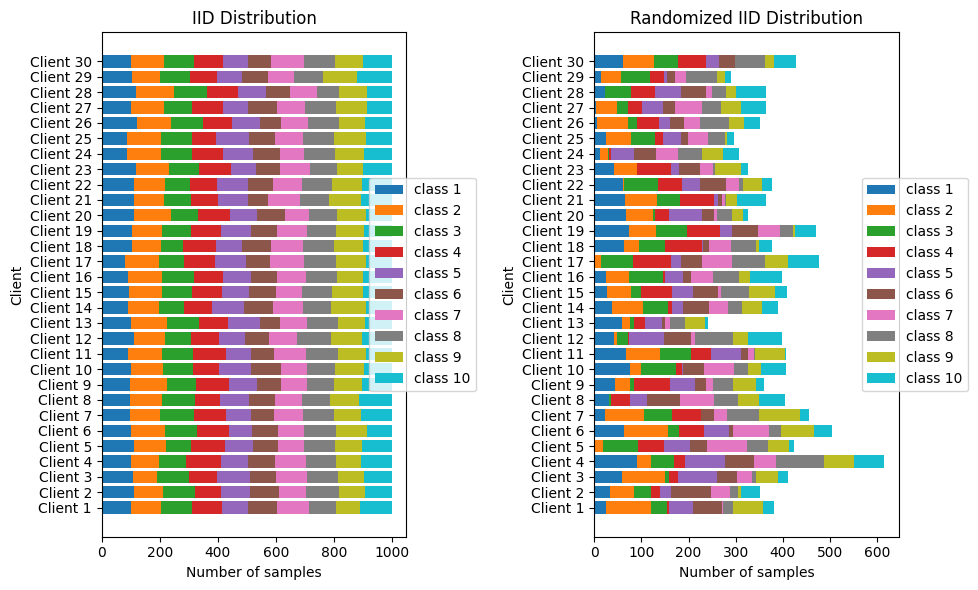

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute class distributions for a set of client data
def compute_class_distributions(client_data, num_classes=10):
    distributions = []
    for x_client, y_client in client_data:
        class_counts = torch.bincount(y_client, minlength=num_classes)
        distributions.append(class_counts.numpy())
    return np.array(distributions).T  # Transpose to get a list of class-wise distributions

# Plotting function as provided
def plot_distributions(iid_dist, random_iid_dist, num_users):
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plot_sample_stats(iid_dist, num_users)
    plt.title("IID Distribution")
    
    plt.subplot(1, 2, 2)
    plot_sample_stats(random_iid_dist, num_users)
    plt.title("Randomized IID Distribution")
    
    plt.tight_layout()
    plt.show()

def plot_sample_stats(dist, num_users):
    classes = [f'class {i+1}' for i in range(len(dist))]
    for i in range(len(classes)):
        left = sum(dist[j][:num_users] for j in range(i))
        plt.barh(range(num_users), dist[i][:num_users], left=left, label=classes[i])
    plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.yticks(range(num_users), [f'Client {i+1}' for i in range(num_users)])
    plt.xlabel('Number of samples')
    plt.ylabel('Client')

# Example usage of the distribution plot
num_clients = 30

# Assuming client_data_iid and client_data_non_iid are already created (from the previous step)
iid_distributions = compute_class_distributions(client_data_iid)
non_iid_distributions = compute_class_distributions(client_data_non_iid)

# Plot the distributions for IID and non-IID (random) splits
plot_distributions(iid_distributions, non_iid_distributions, num_clients)


# testing

## testing root loader

In [8]:
import copy
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from dataloaders import ClientDataLoader, RootClientDataLoader, load_test_data
from server import Server
from client import Client, RootClient
from model import LeNet
import numpy as np
import os

# Load test data
test_loader = load_test_data()

model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Load the Client DataLoader with dynamic malicious client selection
client_data_loader = ClientDataLoader(num_clients=30, num_malicious=3, batch_size=64, attack_type='label_flipping')
client_datasets = client_data_loader.get_client_datasets()
malicious_clients = client_data_loader.get_malicious_clients()

# Initialize clients with dynamic malicious status
clients = []
for client_id, train_loader in enumerate(client_datasets):
    is_malicious = client_id in malicious_clients  # Dynamically assign malicious clients
    clients.append(Client(model=model, criterion=criterion, client_loader=train_loader, client_id=client_id, 
    is_malicious=is_malicious))

# Load the RootClient data
root_loader = RootClientDataLoader(batch_size=64)
root_client = RootClient(model=model, criterion=criterion, root_loader=root_loader, num_epochs=2)

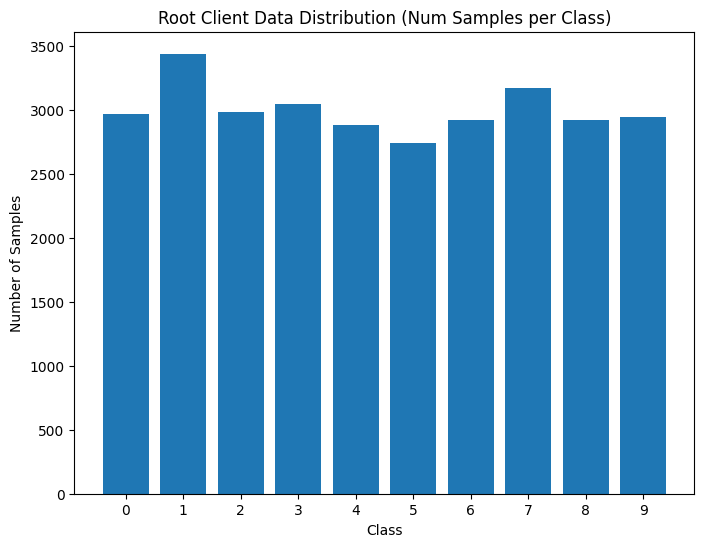

In [10]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

def visualize_root_client_dataloader(root_loader):
    class_counts = torch.zeros(10)  # Assuming 10 classes in the dataset (like MNIST)

    # Count the number of samples per class
    for _, targets in root_loader:
        class_counts += torch.bincount(targets, minlength=10)

    # Plot the distribution
    plt.figure(figsize=(8, 6))
    plt.bar(range(10), class_counts.numpy(), tick_label=[str(i) for i in range(10)])
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title("Root Client Data Distribution (Num Samples per Class)")
    plt.show()

# Example usage:
root_client_loader = RootClientDataLoader(batch_size=64).get_dataloader()
visualize_root_client_dataloader(root_client_loader)


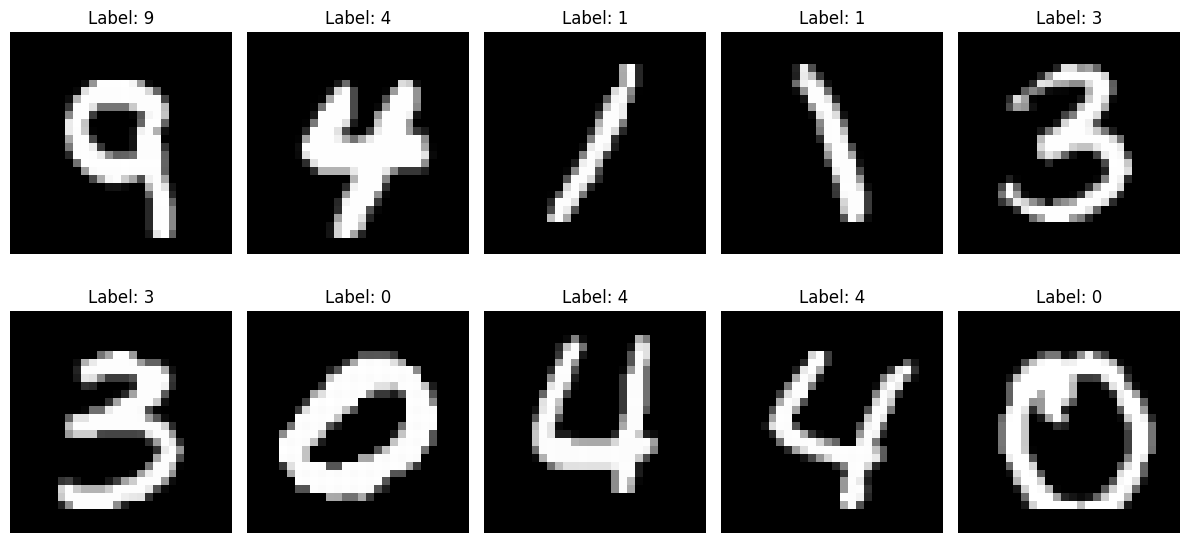

In [12]:
def visualize_images_and_labels(root_loader):
    """Visualize images and corresponding labels from the root client DataLoader."""
    images, labels = next(iter(root_loader))  # Get the first batch of images and labels
    images = images[:10]  # Take the first 10 images to display

    # Plot the images along with their labels
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].view(28, 28), cmap="gray")  # Reshape the flattened image to 28x28
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_images_and_labels(root_client_loader)


Shape of images: torch.Size([64, 784])
Shape of labels: torch.Size([64])


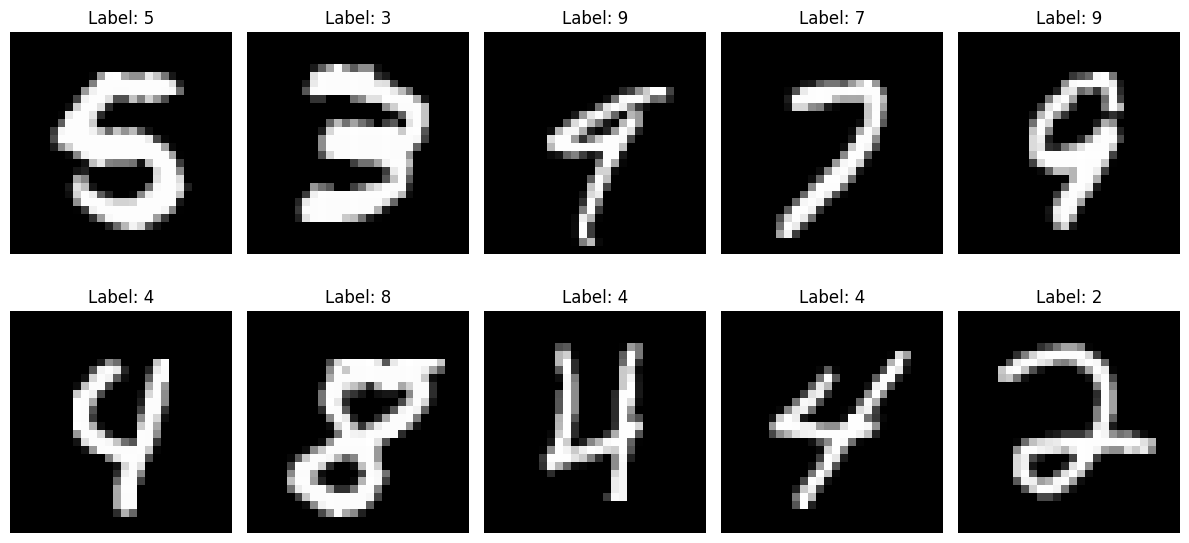

Shape of images: torch.Size([64, 784])
Shape of labels: torch.Size([64])


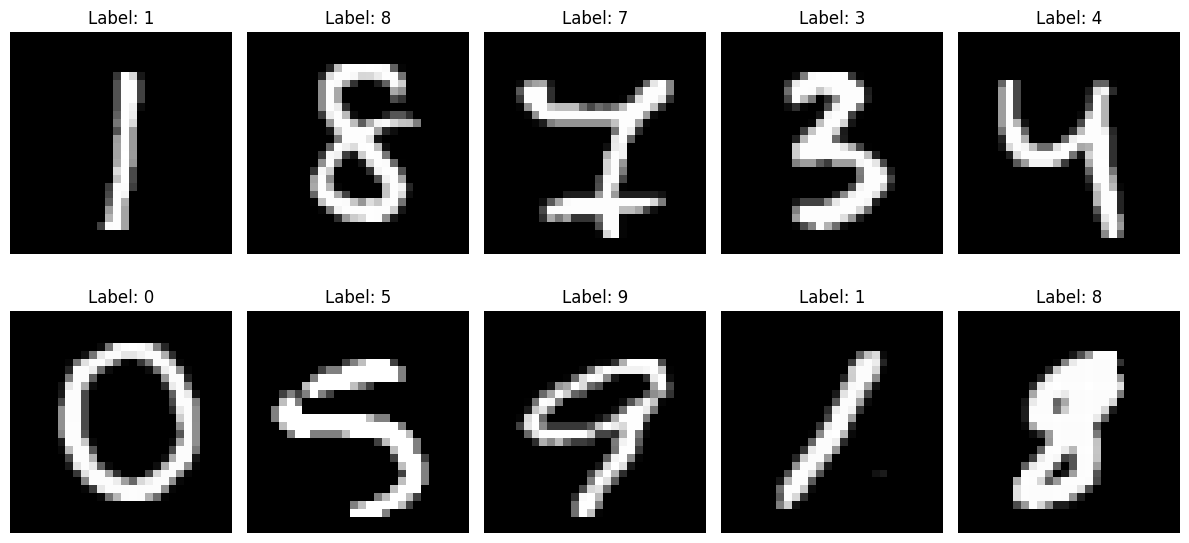

In [13]:
def print_shapes_and_visualize_images(dataloader):
    """Print the shapes of the batches in the dataloader and visualize the first batch of images."""
    images, labels = next(iter(dataloader))  # Get the first batch of images and labels
    
    # Print shapes
    print(f"Shape of images: {images.shape}")
    print(f"Shape of labels: {labels.shape}")
    
    # Plot the images along with their labels
    plt.figure(figsize=(12, 6))
    for i in range(10):  # Visualize first 10 images
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].view(28, 28), cmap="gray")  # Reshape the flattened image to 28x28
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage for RootClientDataLoader:
root_client_loader = RootClientDataLoader(batch_size=64).get_dataloader()
print_shapes_and_visualize_images(root_client_loader)

# Example usage for a ClientDataLoader (for a specific client):
client_dataloader = ClientDataLoader(num_clients=30, num_malicious=3, batch_size=64).get_client_datasets()[0]
print_shapes_and_visualize_images(client_dataloader)



# FedAvg vs FLTrust

In [ ]:
import matplotlib.pyplot as plt

# Data for accuracies
Fedavg = [9.8, 33.58, 49.39, 84.97, 90.85, 93.04, 94.45, 95.17, 95.92, 96.39, 96.67]
Root = [10.246666666666666, 96.87, 97.09666666666666, 96.83333333333333, 96.86333333333333, 97.06, 96.84666666666666, 97.23666666666666, 96.97, 97.38666666666667, 96.45666666666666]
FLTrust = [10.3, 10.09, 10.86, 10.09, 76.5, 10.09, 79.39, 10.09, 91.28, 10.09, 91.84]

# X-axis for rounds
rounds = list(range(1, 12))

# Plot Global Model Accuracies
plt.figure(figsize=(10, 6))

plt.plot(rounds, Fedavg, label="fedavg", marker='o')
plt.plot(rounds, Root, label="Root", marker='o')
plt.plot(rounds, FLTrust, label="FLTrust", marker='o')

plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Fed Avg vs FLTrust, Normal training")
plt.legend()
plt.grid(True)
plt.show()

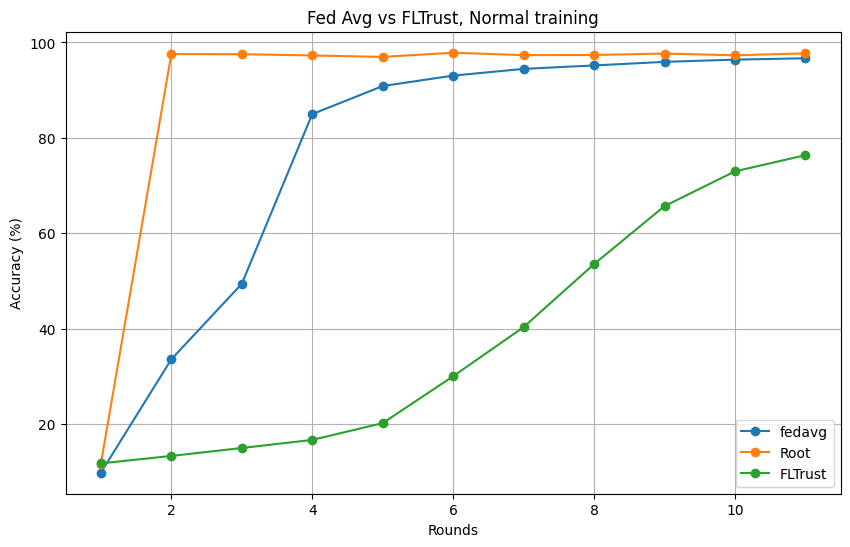

In [3]:
import matplotlib.pyplot as plt

# Data for accuracies
Fedavg = [9.8, 33.58, 49.39, 84.97, 90.85, 93.04, 94.45, 95.17, 95.92, 96.39, 96.67]
Root = [11.686666666666667, 97.56333333333333, 97.52333333333333, 97.26, 96.96333333333334, 97.83666666666667, 97.32666666666667, 97.36, 97.66, 97.29666666666667, 97.7]
FLTrust = [11.76, 13.32, 14.98, 16.68, 20.2, 30.02, 40.32, 53.53, 65.68, 72.97, 76.36]

# X-axis for rounds
rounds = list(range(1, 12))

# Plot Global Model Accuracies
plt.figure(figsize=(10, 6))

plt.plot(rounds, Fedavg, label="fedavg", marker='o')
plt.plot(rounds, Root, label="Root", marker='o')
plt.plot(rounds, FLTrust, label="FLTrust", marker='o')

plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Fed Avg vs FLTrust, Normal training")
plt.legend()
plt.grid(True)
plt.show()

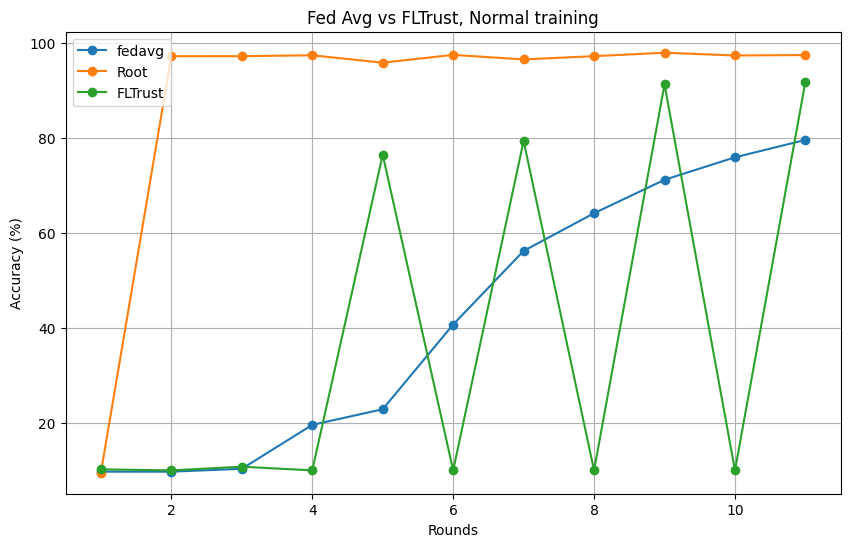

In [4]:
import matplotlib.pyplot as plt

# Data for accuracies
Fedavg =  [3.29, 10.09, 14.07, 56.62, 25.82, 92.17, 10.14, 93.6, 10.09, 94.06, 10.14]
Root = [9.596666666666666, 97.21, 97.21333333333334, 97.40333333333334, 95.84, 97.48666666666666, 96.53, 97.21666666666667, 97.94, 97.36, 97.45]
FLTrust = [10.3, 10.09, 10.86, 10.09, 76.5, 10.09, 79.39, 10.09, 91.28, 10.09, 91.84]

# X-axis for rounds
rounds = list(range(1, 12))

# Plot Global Model Accuracies
plt.figure(figsize=(10, 6))

plt.plot(rounds, Fedavg, label="fedavg", marker='o')
plt.plot(rounds, Root, label="Root", marker='o')
plt.plot(rounds, FLTrust, label="FLTrust", marker='o')

plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Fed Avg vs FLTrust, Normal training")
plt.legend()
plt.grid(True)
plt.show()

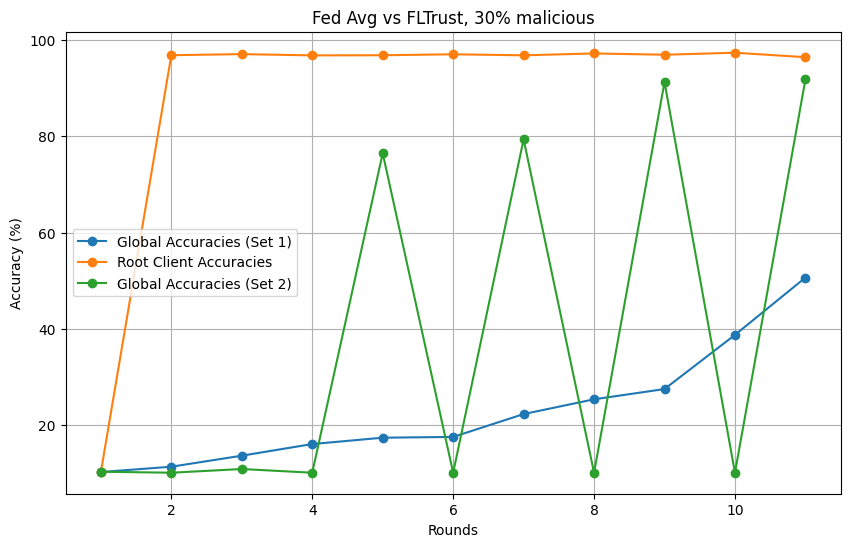

In [2]:
import matplotlib.pyplot as plt

# Data for accuracies
global_accuracies_fltrust_1 = [10.23, 11.34, 13.63, 16.05, 17.37, 17.53, 22.28, 25.35, 27.48, 38.74, 50.65]
root_accuracies = [10.246666666666666, 96.87, 97.09666666666666, 96.83333333333333, 96.86333333333333, 97.06, 96.84666666666666, 97.23666666666666, 96.97, 97.38666666666667, 96.45666666666666]
global_accuracies_fltrust_2 = [10.3, 10.09, 10.86, 10.09, 76.5, 10.09, 79.39, 10.09, 91.28, 10.09, 91.84]

# X-axis for rounds
rounds = list(range(1, 12))

# Plot Global Model Accuracies
plt.figure(figsize=(10, 6))

plt.plot(rounds, global_accuracies_fltrust_1, label="Global Accuracies (Set 1)", marker='o')
plt.plot(rounds, root_accuracies, label="Root Client Accuracies", marker='o')
plt.plot(rounds, global_accuracies_fltrust_2, label="Global Accuracies (Set 2)", marker='o')

plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Fed Avg vs FLTrust, 30% malicious")
plt.legend()
plt.grid(True)
plt.show()